# Introduction
In this notebook, we will explore language models we can build with SageMaker, namely BalzingText,  to detect vital info in news articles. 

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import sagemaker
import boto3
import json
import matplotlib.pyplot as plt

from covid.config import Config

# Setup

In [3]:
config = Config('../config.json')

bucket = 'mleila-covid'
prefix = 'models/'
region_name = boto3.Session().region_name

sess = sagemaker.Session()
role = config.SM_ROLE

# Training

## Create Model

In [4]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [5]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.2xlarge', # Use of ml.p3.2xlarge is highly recommended for highest speed and cost efficiency
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

## Set Hyper-parameters

In [6]:
bt_model.set_hyperparameters(mode="skipgram",
                             epochs=5,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=100,
                             negative_samples=5,
                             subwords=True, # Enables learning of subword embeddings for OOV word vector generation
                             min_char=3, # min length of char ngrams
                             max_char=6, # max length of char ngrams
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True)# Perform similarity evaluation on WS-353 dataset at the end of training

## train

In [9]:
s3_train_data = 's3://{}/raw/covid'.format(bucket)
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

In [12]:
bt_model.fit(inputs=data_channels, logs=True)

2020-03-27 00:14:57 Starting - Starting the training job...
2020-03-27 00:14:59 Starting - Launching requested ML instances............
2020-03-27 00:17:04 Starting - Preparing the instances for training......
2020-03-27 00:18:19 Downloading - Downloading input data
2020-03-27 00:18:19 Training - Downloading the training image..Arguments: train
[03/27/2020 00:18:37 WARNING 140279356675904] Loggers have already been setup.
[03/27/2020 00:18:37 WARNING 140279356675904] Loggers have already been setup.
[03/27/2020 00:18:37 INFO 140279356675904] nvidia-smi took: 0.0252499580383 secs to identify 0 gpus
[03/27/2020 00:18:37 INFO 140279356675904] Running single machine CPU BlazingText training using skipgram mode.
[03/27/2020 00:18:37 INFO 140279356675904] Processing /opt/ml/input/data/train/articles.txt . File size: 0 MB
Read 0M words
Number of words:  107
##### Alpha: -0.0008  Progress: 101.65%  Million Words/sec: 0.02 #####
##### Alpha: 0.0000  Progress: 100.00%  Million Words/sec: 0.02 ##

# Deploy Endpoint

In [13]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

---------------!

# Predict

In [18]:
words = ["covid", "virus"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs = json.loads(response)
covid_vector, virus_vector = vecs

# Visualize with TSNE

In [26]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [27]:
!tar -xvzf model.tar.gz

x vectors.bin
x vectors.txt
x eval.json


In [37]:
import numpy as np

from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 800

first_line = True
index_to_word = []
with open("vectors.txt", "r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break

word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

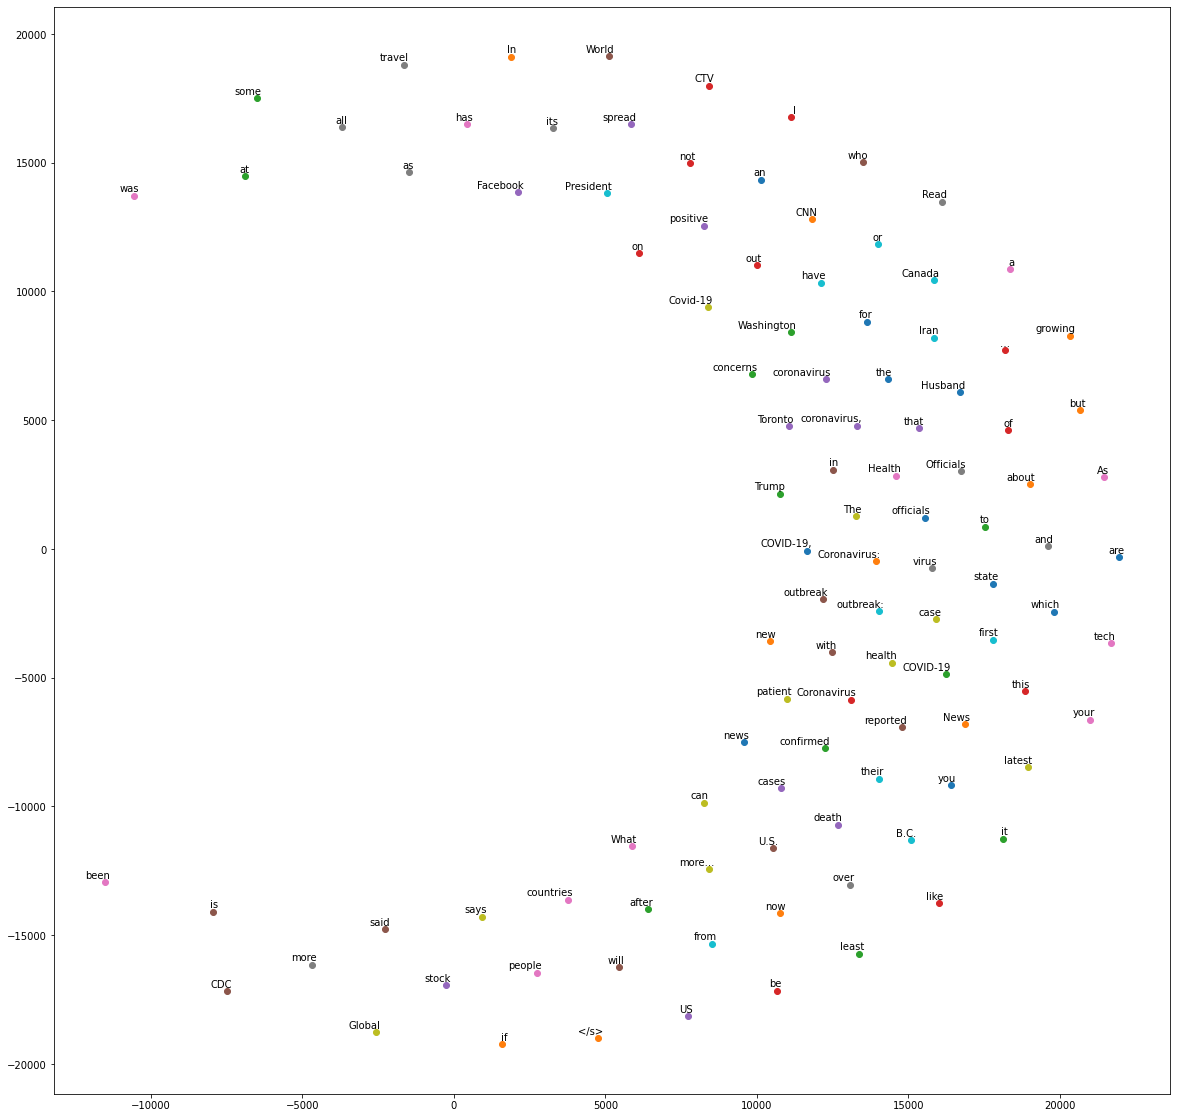

In [39]:
%matplotlib inline

def plot(embeddings, labels):
    plt.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    plt.show()

plot(two_d_embeddings, labels)

# Shutdown Endpoint

In [55]:
sess.delete_endpoint(bt_endpoint.endpoint)